In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import json

from statistics import mode

In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [3]:
%run 02_Daten_laden.ipynb

In [4]:
irony_subset = irony_final[:1001]
irony_subset

,index,Label,text
0,0,1,Sweet United Nations video. Just in time for C...
1,1,1,@mrdahl87 We are rumored to have talked to Erv...
2,2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,3,0,3 episodes left I'm dying over here
4,4,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
996,996,0,It was a greaaaat night! :white_smiling_face:️...
997,997,0,@StephHammy I wonder if they have that in an a...
998,998,0,Queens Of The Stone Age no Rock In Rio http://...
999,999,1,@jordyn_eaton wants me to get hit by a bus so ...


## OpenAI / GPT

In [10]:
openai_client

### ABSA

In [5]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [10]:
irony_subset = irony_final[:1001]
irony_subset

,index,Label,text
0,0,1,Sweet United Nations video. Just in time for C...
1,1,1,@mrdahl87 We are rumored to have talked to Erv...
2,2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,3,0,3 episodes left I'm dying over here
4,4,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
996,996,0,It was a greaaaat night! :white_smiling_face:️...
997,997,0,@StephHammy I wonder if they have that in an a...
998,998,0,Queens Of The Stone Age no Rock In Rio http://...
999,999,1,@jordyn_eaton wants me to get hit by a bus so ...


In [11]:
## Prompts

system_prompt = """You determine whether a text contains ironic or sarcastic elements. 
Analyze the text carefully and explain your reasoning step-by-step before providing the final answer. 
                    Return 0 for No and 1 for Yes.

                    ### Example ###
                    Q: Does the following text contain ironic or sarcastic elements?  Text: "That moment when you have so much stuff to do but you open @tumblr … #productivity #tumblr"
                    A: The sentence “That moment when you have so much stuff to do but you open @tumblr … #productivity #tumblr” can be classified as ironic for several reasons.
                    First, the speaker mentions having “so much stuff to do,” which implies a sense of urgency or the need to be productive. This would normally suggest that they should focus on their tasks.
                    However, instead of working on these tasks, the speaker states that they opened Tumblr, a platform often associated with leisure, distraction, and procrastination rather than productivity. The speaker juxtaposes the idea of needing to be productive with the act of wasting time on Tumblr, which creates a contradiction between expectations and reality.
                    Moreover, the use of hashtags like “#productivity” adds to the irony. By labeling their unproductive behavior as “productivity,” the speaker knowingly highlights the absurdity of their situation. The hashtags suggest that the speaker is aware of the contradiction, further reinforcing the ironic tone.
                    In summary, the irony comes from the mismatch between the expectation of being productive and the reality of procrastinating on Tumblr, with the hashtags emphasizing this contrast in a humorous way.
                    """

user_prompt = "Does the following text contain ironic or sarcastic elements?"


# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence', 'steps', 'answers', 'generated_label']) 

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Self Consistency durchläufe
n = 3

# Schleife mit API-Call
for index, row in irony_subset.iterrows():
    text = row['text']
    #print(text)

    answers = []
    all_steps = []

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse(
            model="gpt-4o-mini", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                {
                "role":"system",
                "content": system_prompt
                },
                {
                "role": "user",
                 "content": (user_prompt + "Text: " + f"{text}")
                }
            ],
            temperature = 0.5,
            response_format=CoT,
            n = n
        )

        for i in range(n):
            response_content = response.choices[i].message.parsed #response.choices[0].message.content
            
            result_step = response_content.steps
            final_answer = response_content.final_answer

            # Speichern der finalen Antwort und Schritte
            answers.append(final_answer)
            all_steps.append(result_step)
            print(index, "n= ",i , "Label: ",final_answer )

           # Häufigste Antwort bestimmen
        if answers:
            consistent_answer = mode(answers)

            # Ergebnis in das DataFrame speichern, all_steps wird zu einer Zeichenkette konvertiert
            results_gpt_df.loc[row_counter] = [index, text, all_steps, answers, consistent_answer]

            row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0 n=  0 Label:  1
0 n=  1 Label:  1
0 n=  2 Label:  1
1 n=  0 Label:  1
1 n=  1 Label:  1
1 n=  2 Label:  1
2 n=  0 Label:  1
2 n=  1 Label:  1
2 n=  2 Label:  1
3 n=  0 Label:  1
3 n=  1 Label:  1
3 n=  2 Label:  1
4 n=  0 Label:  1
4 n=  1 Label:  0
4 n=  2 Label:  0
5 n=  0 Label:  1
5 n=  1 Label:  1
5 n=  2 Label:  1
6 n=  0 Label:  1
6 n=  1 Label:  1
6 n=  2 Label:  1
7 n=  0 Label:  1
7 n=  1 Label:  0
7 n=  2 Label:  1
8 n=  0 Label:  0
8 n=  1 Label:  1
8 n=  2 Label:  1
9 n=  0 Label:  0
9 n=  1 Label:  0
9 n=  2 Label:  0
10 n=  0 Label:  1
10 n=  1 Label:  1
10 n=  2 Label:  1
11 n=  0 Label:  1
11 n=  1 Label:  1
11 n=  2 Label:  1
12 n=  0 Label:  1
12 n=  1 Label:  1
12 n=  2 Label:  1
13 n=  0 Label:  1
13 n=  1 Label:  0
13 n=  2 Label:  1
14 n=  0 Label:  1
14 n=  1 Label:  1
14 n=  2 Label:  1
15 n=  0 Label:  1
15 n=  1 Label:  1
15 n=  2 Label:  1
16 n=  0 Label:  1
16 n=  1 Label:  1
16 n=  2 Label:  1
17 n=  0 Label:  1
17 n=  1 Label:  1
17 n=  2 Label:  1
18 n

KeyboardInterrupt: 

In [12]:
results_gpt_df

,index,sentence,steps,answers,generated_label
0,0,Sweet United Nations video. Just in time for C...,"[[explanation='The phrase ""Sweet United Nation...","[1, 1, 1]",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[[explanation='The phrase ""that\'s hardly noth...","[1, 1, 1]",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"[[explanation='The greeting ""Hey there! Nice t...","[1, 1, 1]",1
3,3,3 episodes left I'm dying over here,"[[explanation=""The phrase '3 episodes left' in...","[1, 1, 1]",1
4,4,I can't breathe! was chosen as the most notabl...,"[[explanation='The phrase ""I can\'t breathe!"" ...","[1, 0, 0]",0
...,...,...,...,...,...
946,946,What an eventful weekend,"[[explanation='The phrase ""What an eventful we...","[0, 0, 1]",0
947,947,@MLS @ussoccer Awesome destination site. High ...,"[[explanation=""The text makes a positive state...","[1, 1, 1]",1
948,948,"Kyle it won't let me @ you? But yeah, we are g...","[[explanation=""The text starts with 'Kyle it w...","[1, 1, 1]",1
949,949,"@Parlett316 that's where you are wrong, I can ...",[[explanation='The speaker responds to someone...,"[0, 0, 0]",0


In [13]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_final = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

#results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].replace({'negative': 0, 'positive': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final_ver = results_gpt_df_final[results_gpt_df_final['generated_label'].isin(['0', '1',0, 1])]

# als int formatieren
results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)




In [14]:
results_gpt_df_final_ver

,index,sentence,steps,answers,generated_label
0,0,Sweet United Nations video. Just in time for C...,"[[explanation='The phrase ""Sweet United Nation...","[1, 1, 1]",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[[explanation='The phrase ""that\'s hardly noth...","[1, 1, 1]",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"[[explanation='The greeting ""Hey there! Nice t...","[1, 1, 1]",1
3,3,3 episodes left I'm dying over here,"[[explanation=""The phrase '3 episodes left' in...","[1, 1, 1]",1
4,4,I can't breathe! was chosen as the most notabl...,"[[explanation='The phrase ""I can\'t breathe!"" ...","[1, 0, 0]",0
...,...,...,...,...,...
946,946,What an eventful weekend,"[[explanation='The phrase ""What an eventful we...","[0, 0, 1]",0
947,947,@MLS @ussoccer Awesome destination site. High ...,"[[explanation=""The text makes a positive state...","[1, 1, 1]",1
948,948,"Kyle it won't let me @ you? But yeah, we are g...","[[explanation=""The text starts with 'Kyle it w...","[1, 1, 1]",1
949,949,"@Parlett316 that's where you are wrong, I can ...",[[explanation='The speaker responds to someone...,"[0, 0, 0]",0


In [15]:

# CSV abspeichern 
results_gpt_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/MAST_SelfConsistency_GPT.csv', encoding='utf-8-sig')


### Evaluation

In [16]:

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(irony_subset, results_gpt_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['Label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.61
Precision: 0.58
Recall: 0.89
F1-Score: 0.70
Confusion Matrix:
[[151 313]
 [ 56 431]]


In [ ]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['negativ', 'positiv', 'neutral']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

### SemEval-2014

In [21]:
irony_subset = irony_final[:1001]
irony_subset

,index,Label,text
0,0,1,Sweet United Nations video. Just in time for C...
1,1,1,@mrdahl87 We are rumored to have talked to Erv...
2,2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,3,0,3 episodes left I'm dying over here
4,4,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
996,996,0,It was a greaaaat night! :white_smiling_face:️...
997,997,0,@StephHammy I wonder if they have that in an a...
998,998,0,Queens Of The Stone Age no Rock In Rio http://...
999,999,1,@jordyn_eaton wants me to get hit by a bus so ...


In [22]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""You determine whether a text contains ironic or sarcastic elements. 
                    Analyze the text carefully and explain your reasoning step-by-step before providing the final answer. 
                    Return 0 for No and 1 for Yes. Use this JSON Schema: Result = {'steps':str, 'final_answer': str} 
    """,
    generation_config={"response_mime_type": "application/json","temperature":0.8})

# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence', 'all_steps', 'all_labels', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Anzahl der Wiederholungen für Self-Consistency
num_samples = 3

# Schleife mit API-Call
for index, row in irony_subset.iterrows():
    text = row['text']
    
    # Liste zum Speichern von Antworten und deren Details
    answers = []
    all_steps = []
    
    try:
        # Self-Consistency: Mehrere Antworten generieren
        for _ in range(num_samples):
            # GenAI Model-Aufruf für die Sentiment-Klassifikation
            response = genai_model.generate_content(f"""Does the following text contains ironic or sarcastic elements? Text: {text}""")
            llm_output = response.text
         
            # Antwort parsen und speichern
            resp_dict = json.loads(llm_output)
            steps = resp_dict['steps']
            final_result = resp_dict['final_answer']

            # In Liste hinzufügen
            answers.append(final_result)
            all_steps.append(steps)

            print("Index: ", index, "n= ",_ , "Label: ", final_result)

        
        # Mehrheit der final answers bestimmen (Voting-Mechanismus)
        try:
            most_common_answer = mode(answers)
        except StatisticsError:
            # Wenn mehrere Modi vorhanden sind, nimm den ersten Wert von multimode()
            most_common_answer = multimode(answers)[0]
            print(f"Mehrere häufigste Antworten für Index {index}, Auswahl: {most_common_answer}")


        # Ergebnis in das DataFrame speichern
        results_gemini_df.loc[row_counter] = [index, text, all_steps, answers, most_common_answer]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")

Index:  0 n=  0 Label:  1
Index:  0 n=  1 Label:  1
Index:  0 n=  2 Label:  1
Index:  1 n=  0 Label:  1
Index:  1 n=  1 Label:  1
Index:  1 n=  2 Label:  1
Index:  2 n=  0 Label:  1
Index:  2 n=  1 Label:  1
Index:  2 n=  2 Label:  1
Index:  3 n=  0 Label:  1
Index:  3 n=  1 Label:  1
Index:  3 n=  2 Label:  1
Index:  4 n=  0 Label:  1
Index:  4 n=  1 Label:  1
Index:  4 n=  2 Label:  1
Index:  5 n=  0 Label:  1
Index:  5 n=  1 Label:  1
Index:  5 n=  2 Label:  1
Index:  6 n=  0 Label:  1
Index:  6 n=  1 Label:  1
Index:  6 n=  2 Label:  1
Index:  7 n=  0 Label:  1
Index:  7 n=  1 Label:  1
Index:  7 n=  2 Label:  1
Index:  8 n=  0 Label:  1
Index:  8 n=  1 Label:  1
Index:  8 n=  2 Label:  1
Index:  9 n=  0 Label:  0
Index:  9 n=  1 Label:  0
Index:  9 n=  2 Label:  0
Index:  10 n=  0 Label:  1
Index:  10 n=  1 Label:  1
Index:  10 n=  2 Label:  1
Index:  11 n=  0 Label:  1
Index:  11 n=  1 Label:  1
Index:  11 n=  2 Label:  1
Index:  12 n=  0 Label:  1
Index:  12 n=  1 Label:  0
Inde

In [24]:
results_gemini_df

,index,sentence,all_steps,all_labels,generated_label
0,0,Sweet United Nations video. Just in time for C...,[The text expresses a negative sentiment towar...,"[1, 1, 1]",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[The text uses a wink emoji, which is often us...","[1, 1, 1]",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,[The text expresses a greeting followed by a s...,"[1, 1, 1]",1
3,3,3 episodes left I'm dying over here,"[The statement ""3 episodes left I'm dying over...","[1, 1, 1]",1
4,4,I can't breathe! was chosen as the most notabl...,"[The text mentions ""I can't breathe!"" being ch...","[1, 1, 1]",1
...,...,...,...,...,...
992,996,It was a greaaaat night! :white_smiling_face:️...,[The text uses multiple emojis expressing posi...,"[1, 1, 1]",1
993,997,@StephHammy I wonder if they have that in an a...,"[The text is a tweet directed at another user,...","[1, 1, 1]",1
994,998,Queens Of The Stone Age no Rock In Rio http://...,"[The text mentions ""Queens Of The Stone Age"" a...","[1, 1, 0]",1
995,999,@jordyn_eaton wants me to get hit by a bus so ...,[The text expresses a humorous and exaggerated...,"[1, 1, 1]",1


In [25]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({'no': 0, 'yes': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1,'0','1'])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




In [26]:
results_gemini_df_final_ver

,index,sentence,all_steps,all_labels,generated_label
0,0,Sweet United Nations video. Just in time for C...,[The text expresses a negative sentiment towar...,"[1, 1, 1]",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[The text uses a wink emoji, which is often us...","[1, 1, 1]",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,[The text expresses a greeting followed by a s...,"[1, 1, 1]",1
3,3,3 episodes left I'm dying over here,"[The statement ""3 episodes left I'm dying over...","[1, 1, 1]",1
4,4,I can't breathe! was chosen as the most notabl...,"[The text mentions ""I can't breathe!"" being ch...","[1, 1, 1]",1
...,...,...,...,...,...
992,996,It was a greaaaat night! :white_smiling_face:️...,[The text uses multiple emojis expressing posi...,"[1, 1, 1]",1
993,997,@StephHammy I wonder if they have that in an a...,"[The text is a tweet directed at another user,...","[1, 1, 1]",1
994,998,Queens Of The Stone Age no Rock In Rio http://...,"[The text mentions ""Queens Of The Stone Age"" a...","[1, 1, 0]",1
995,999,@jordyn_eaton wants me to get hit by a bus so ...,[The text expresses a humorous and exaggerated...,"[1, 1, 1]",1


In [27]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv("""/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/MAST_SelfConsistency_GEMINI.csv""")


#### Evaluation

In [28]:


# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(irony_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['Label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.56
Precision: 0.54
Recall: 0.96
F1-Score: 0.69
Confusion Matrix:
[[ 64 423]
 [ 19 491]]


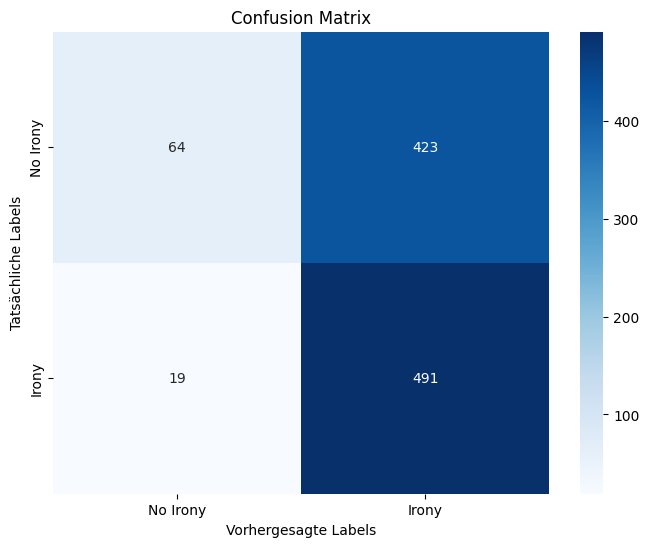

In [29]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['No Irony', 'Irony']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()